<a href="https://colab.research.google.com/github/PsorTheDoctor/pybullet/blob/master/robots/biped/zero_moment_point.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Zero Moment Point

In [ ]:
!pip install -q control

In [46]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import control

In [120]:
CoM_height = 0.5
g = 9.81
dt = 0.001
M = 1000
stride = 0.1

supportPoint = np.array([[0.0, -0.065],
                         [stride, 0.065],
                         [stride * 2, -0.065],
                         [stride * 3, 0.065],
                         [stride * 4, -0.065],
                         [stride * 5, 0.065]])

supportPointNum = len(supportPoint)

Tsup = int(0.5 / dt)
Tdl = int(0.1 / dt)
k_max = int(M + (Tsup * 6))

max_k = (Tsup + Tdl) * (supportPointNum - 1) + Tsup

x_tdl_a = np.zeros(supportPointNum - 1)
x_tdl_b = np.zeros(supportPointNum - 1)
y_tdl_a = np.zeros(supportPointNum - 1)
y_tdl_b = np.zeros(supportPointNum - 1)

for i in range(supportPointNum - 1):
  x_tdl_a[i] = (supportPoint[i, 0] - supportPoint[i+1, 0]) / (-Tdl * dt)
  x_tdl_b[i] = supportPoint[i, 0] - x_tdl_a[i] * ((i+1)*Tsup*dt + i*Tdl*dt)

for i in range(supportPointNum - 1):
  y_tdl_a[i] = (supportPoint[i, 0] - supportPoint[i+1, 1]) / (-Tdl * dt)
  y_tdl_b[i] = supportPoint[i, 0] - y_tdl_a[i] * ((i+1)*Tsup*dt + i*Tdl*dt)

tdl_t = []
tdl_t.append(np.arange(Tsup*dt, Tsup*dt + Tdl*dt, dt))
for i in range(0, supportPointNum - 2):
  tdl_t.append(tdl_t[i] + (Tsup + Tdl) * dt)

px_ref = np.array([])
py_ref = np.array([])

for i in range(supportPointNum - 1):
  px_ref = np.hstack((px_ref, np.array([supportPoint[i, 0] for _ in range(Tsup)])))
  py_ref = np.hstack((py_ref, np.array([supportPoint[i, 1] for _ in range(Tsup)])))
  px_ref = np.hstack((px_ref, np.array(x_tdl_a[i] * tdl_t[i] + x_tdl_b[i])))
  py_ref = np.hstack((py_ref, np.array(y_tdl_a[i] * tdl_t[i] + y_tdl_b[i])))

px_ref = np.hstack(
    (px_ref, np.array([supportPoint[supportPointNum-1, 0] for _ in range(Tsup)])))
py_ref = np.hstack(
    (py_ref, np.array([supportPoint[supportPointNum-1, 1] for _ in range(Tsup)])))

px_ref = np.hstack((px_ref, np.array([px_ref[-1] for _ in range(M)])))
py_ref = np.hstack((py_ref, np.array([py_ref[-1] for _ in range(M)])))

In [121]:
k = 0
t = 0
A = np.matrix([[1, dt, (dt**2)/2],
               [0, 1, dt],
               [0, 0, 1]])
B = np.matrix([(dt**3)/6, (dt**2)/2, dt]).T
C = np.matrix([1, 0, -CoM_height / g])
Q = np.matrix([[1000, 0, 0, 0],
               [0, 1, 0, 0],
               [0, 0, 1, 0],
               [0, 0, 0, 1]])

R = np.matrix([1.0])
G = np.vstack((-C * B, B))
Gr = np.matrix([1., 0., 0., 0.,]).T
phi = np.hstack((np.matrix([1,0,0,0]).T, np.vstack((-C * A, A))))
P, _, _ = control.dare(phi, G, Q, R)
print(P)

[[ 4.86584531e+05 -1.18138960e+08 -2.68658821e+07 -4.40201236e+04]
 [-1.18138960e+08  3.06187084e+10  6.99371582e+09  1.83845854e+07]
 [-2.68658821e+07  6.99371582e+09  1.59843309e+09  4.42880783e+06]
 [-4.40201236e+04  1.83845854e+07  4.42880783e+06  6.72446007e+04]]


In [122]:
x = np.matrix(np.zeros(3)).T
y = np.matrix(np.zeros(3)).T

x[0] = 0.0
y[0] = 0.0
xu = 0
yu = 0
px = np.array([0.0])
py = np.array([0.0])

x_log = [x[0, 0]]
y_log = [y[0, 0]]
xdu = 0
ydu = 0
dx = np.matrix(np.zeros(3)).T
dy = np.matrix(np.zeros(3)).T

zai = (np.eye(4) - G * la.inv(R + G.T*P*G) * G.T * P) * phi
print(np.round_(zai, 1))

[[  1.   -1.8  -0.2   0. ]
 [  0.    1.    0.    0. ]
 [  0.   -0.    1.    0. ]
 [  0.  -14.9  -3.6   0.9]]


In [123]:
Fr = np.array([])
for i in range(1, M + 1):
  Fr = np.append(Fr, -la.inv(R + G.T * P * G) * G.T * ((zai.T)**(i-1)) * P * Gr)

F = -la.inv(R + G.T * P * G) * G.T * P * phi
print(F)

[[    30.60687236 -14892.83063786  -3630.75690715    -65.03226084]]


In [124]:
for i in range(max_k):
  dpx_ref = px_ref[i + 1] - px_ref[i]
  dpy_ref = py_ref[i + 1] - py_ref[i]

  xe = px_ref[i] - C * x
  ye = py_ref[i] - C * y

  X = phi * np.vstack((xe, dx)) + G * xdu + Gr * dpx_ref
  Y = phi * np.vstack((ye, dy)) + G * ydu + Gr * dpy_ref

  xsum = ysum = 0
  for j in range(1, M + 1):
    xsum += Fr[j - 1] * (px_ref[i + j] - px_ref[i + j - 1])
    ysum += Fr[j - 1] * (py_ref[i + j] - py_ref[i + j - 1])

  xdu = F * X + xsum
  ydu = F * Y + ysum

  xu += xdu
  yu += ydu

  old_x = x
  old_y = y

  x = A * x + B * xu
  y = A * y + B * yu
  
  dx = x - old_x
  dy = y - old_y

  x_log.append(x[0, 0])
  y_log.append(y[0, 0])

  px = np.append(px, C * x)
  py = np.append(py, C * y)

print('x_log: \n', x_log)
print('y_log: \n', y_log)
print('px: \n', px)
print('py: \n', py)

x_log: 
 [0.0, 1.0503879164534057e-10, 9.318802709904787e-10, 3.655134236274047e-09, 9.968172383676763e-09, 2.2051072036348586e-08, 4.253916601113995e-08, 7.449263663621568e-08, 1.2136711374781843e-07, 1.8698526868503233e-07, 2.7550939307032944e-07, 3.9141495046564677e-07, 5.394650881868847e-07, 7.24686095825463e-07, 9.523437963490227e-07, 1.2279208550333054e-06, 1.5570949909115562e-06, 1.9457180749144224e-06, 2.399796098410263e-06, 2.925469995441066e-06, 3.5289973015808277e-06, 4.21673463201939e-06, 4.995120961193486e-06, 5.8706616860462324e-06, 6.849913454794822e-06, 7.939469742921788e-06, 9.145947157976424e-06, 1.0475972454677853e-05, 1.193617024174834e-05, 1.353315136187309e-05, 1.5273501926179372e-05, 1.7163772984651867e-05, 1.921047081395119e-05, 2.142004780417704e-05, 2.3798893926215123e-05, 2.635332876142641e-05, 2.908959407557714e-05, 3.201384691906688e-05, 3.5132153235689005e-05, 3.845048196235135e-05, 4.197469960239405e-05, 4.5710565255365065e-05, 4.966372608635052e-05, 5.38

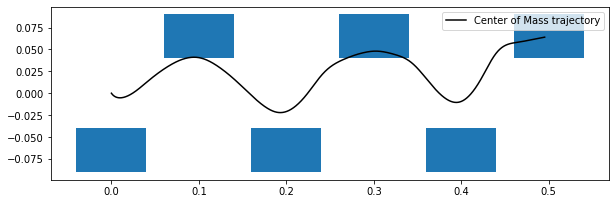

In [133]:
fig = plt.figure(figsize=(10, 10))
CoM = fig.add_subplot(111)
CoM.set_aspect('equal')

footWidth = 0.08
footHeight = 0.05

CoM.plot(x_log, y_log, label='Center of Mass trajectory', color='black')
for i in range(len(supportPoint)):
  CoM.add_patch(Rectangle((supportPoint[i,0] - footWidth/2, supportPoint[i,1] - footHeight/2), 
                          width=footWidth, height=footHeight))
  # CoM.plot(supportPoint[i,0], supportPoint[i,1], marker='s', color='black')
plt.legend()